<a href="https://colab.research.google.com/github/mirklys/little-projects/blob/main/thesis/data_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [25]:
import torch as th
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import pickle
import copy
from collections import defaultdict

In [2]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [3]:
PATH_BASE = '/content/gdrive/MyDrive/Thesis Project'
PATH_DATA = os.path.join(PATH_BASE, 'data/')
PATH_NETWORKS = os.path.join(PATH_BASE, 'networks/')
PATH_PLOTS = os.path.join(PATH_BASE, 'plots/')
PATH_RESULTS = os.path.join(PATH_BASE, 'results/')
PATH_LOGS = os.path.join(PATH_BASE, 'logs/')
os.chdir(PATH_BASE)

In [4]:
def smooth(scalars: np.ndarray, weight: float) -> np.ndarray:  # Weight between 0 and 1
    last = scalars[0]  # First value in the plot (first timestep)
    smoothed = list()
    for point in scalars:
        smoothed_val = last * weight + (1 - weight) * point  # Calculate smoothed value
        smoothed.append(smoothed_val)                        # Save it
        last = smoothed_val                                  # Anchor the last smoothed value

    return np.array(smoothed)

In [5]:
def sparsederror(m: np.ndarray, smoothed_mean: np.ndarray, smoothed_std: np.ndarray) -> tuple:
    sparsed_indx = np.random.randint(3, 10)
    mm, y, e = [], [], []
    t = 0
    
    for i, j, k in zip(m, smoothed_mean, smoothed_std):
        if t % sparsed_indx == 0:
            mm.append(i)
            y.append(j)
            e.append(k)
        t += 1
    return np.array(mm), np.array(y), np.array(e)

In [6]:
def perf_rew_plot(data: dict, game: str):
    plt.rcParams.update({'errorbar.capsize': 5, 'font.size': 12, 'font.family': 'Times New Roman'})
    colors = plt.cm.winter(np.linspace(0, 1, 5))
    plt.style.use('seaborn')

    for size, v in data.items():
        fig, ax = plt.subplots(figsize=(18,9))
        #colors = plt.cm.jet(np.linspace(0, 1, len(v[0])))
        for d, color in zip(v, colors):
            dropout, x, mean_rew, std_rew = d[0], d[1], d[2], d[3]
            dropout = dropout[0]
            ste_rew = np.array(std_rew)/np.sqrt(len(std_rew))
            smoothed_mean = smooth(mean_rew, .8)
            smoothed_ste = smooth(ste_rew, .8)

            ax.fill_between(np.array(x)*100, smoothed_mean-smoothed_ste, smoothed_mean+smoothed_ste, color=color, alpha=.25)
            ax.plot(np.array(x)*100, smoothed_mean, color=color, label="{}% dropout".format(int(dropout*100)), linewidth=3)
            ax.annotate(str(round(smoothed_mean[0], 1)), xy=(x[0],smoothed_mean[0]))

        ax.set_ylabel("average cumulative reward")
        ax.set_xlabel("mask size, %")
        title = "Performance of MLP policy network ({}x{}) with second masked layer at increasing dropout rates".format(size, size)
        fig.suptitle(title, fontsize=12, y=.93, fontname="sans-serif", fontweight="bold")
        ax.legend(loc="best")

        plt.savefig(os.path.join(PATH_PLOTS,game,title+".png"))

In [7]:
#@title
def parse_file_name(file: str) -> tuple:
    splitted = file.split(".")
    game = splitted[0]
    size = splitted[1].split("x")[0]
    dropout = float(file.replace("{}.{}x{}.dropout".format(game, size, size), "")[1:][:-7])
    return game, int(size), dropout

In [10]:
def load(path: str, size:bool=False, dropout:bool=False) -> dict: # size|dropout: [[dropout|size,...], [x,...], [mean,...], [std,...]]
    assert size ^ dropout # xor
    data = defaultdict(list)
    loaded = pickle.load(open(path, 'rb'))
    x = np.arange(0., 1.05, .05, dtype=float)
    for (game, net_size, dropout), v in loaded.items():
        net_size = int(net_size)
        try:
            rew, std = v[0]
        except:
            rew, std = v
        if size: data[net_size].append(np.array([[dropout]*len(x), x, rew, std]))
        elif dropout: data[dropout].append(np.array([[net_size]*len(x), x, rew, std]))
    return data

In [11]:
carpole_data_size = load(os.path.join(PATH_RESULTS, 'evaluations_cartpole.pickle'), size=True)

In [ ]:
next(iter(carpole_data_size.items()))

In [ ]:
perf_rew_plot(carpole_data_size, 'cartpole')

In [13]:
carpole_data_dropout = load(os.path.join(PATH_RESULTS, 'evaluations_cartpole.pickle'), dropout=True)

In [15]:
def perf_rew_perdropout_plot(data:dict, game:str):
    plt.rcParams.update({'errorbar.capsize': 5, 'font.size': 12, 'font.family': 'Times New Roman'})
    colors = plt.cm.winter(np.linspace(0, 1, 4))
    plt.style.use('seaborn')

    for dropout, v in data.items():
        fig, ax = plt.subplots(figsize=(24,12))
        for d, color in zip(v, colors):
            size, x, mean_rew, std_rew = d[0], d[1], d[2], d[3]
            size = size[0]
            ste_rew = np.array(std_rew)/np.sqrt(len(std_rew))
            smoothed_mean = smooth(mean_rew, .7)
            smoothed_ste = smooth(ste_rew, .7)

            ax.fill_between(np.array(x)*100, smoothed_mean-smoothed_ste, smoothed_mean+smoothed_ste, color=color, alpha=.25)
            ax.annotate(str(round(smoothed_mean[0], 1)), xy=(x[0],smoothed_mean[0]))
            ax.plot(np.array(x)*100, smoothed_mean, color=color, label="{} size".format(int(size)), linewidth=3)

        title = "Performance of MLP policy networks with second masked layer at {}% dropout".format(dropout*100)
        ax.set_ylabel("average cumulative reward")
        ax.set_xlabel("mask size, %")
        fig.suptitle(title, fontsize=12, y=.93, fontname="sans-serif", fontweight="bold")
        ax.legend(loc="best")

        plt.savefig(os.path.join(PATH_PLOTS,game,title+".png"))

In [ ]:
perf_rew_perdropout_plot(carpole_data_dropout, 'cartpole')

In [21]:
def parse_title(title: str) -> tuple:
    splitted = title.split(".")
    game = splitted[0]
    size = splitted[1].split("x")[0]
    dropout = float(title.split("_")[1])
    return game, size, dropout

In [35]:
def parser_masked_title(name: str) -> tuple:
    # CartPole-v1.128x128.dropout_0.8.mask_0.25.overtrained
    splitted = name.split('.')
    game = splitted[0]
    size = splitted[1].split("x")[0]
    split_underscore = name.split('_') #CartPole-v1.128x128.dropout, 0.8.mask, 0.25.overtrained
    dropout = split_underscore[1].replace('.mask', '')
    mask = split_underscore[2].replace('.overtrained', '')
    return game, size, float(dropout), float(mask)

In [137]:
def load_further_trained_data(path_f: str) -> dict: # (size, dropout): mask, (rew, std, steps)
    data = defaultdict(list)
    loaded_f = pickle.load(open(path_f, 'rb'))

    for name, vals in loaded_f.items():
        game, size, dropout, mask = parser_masked_title(name)
        (rew, std, steps) = vals[0]
        data[int(size), dropout].append((mask, rew, std, steps))

    return data

In [144]:
def concat_originial_further_trained_data(data_f, data_n_size) -> dict: # (size, dropout): ([masks], [rew_original], [std_original], [rew_masked], [std_masked], [steps])
    data_concat = defaultdict(list)
    """
        data_n -- size|dropout: [[dropout|size,...], [x,...], [mean,...], [std,...]]
    """
    for size, v in data_n_size.items():
        for val in v:
            dropout, x, mean_reward, std_reward = tuple(val)
            d = dropout[0]
            mean_reward_masked = mean_reward.copy()
            std_reward_masked = std_reward.copy()
            steps = [0]*len(x)
            eval_f = data_f[size, d]
            for (mask, rew, std, step) in eval_f:
                indx = np.where(x==mask)
                indx=indx[0][0]
                mean_reward_masked[indx] = rew
                std_reward_masked[indx] = std
                steps[indx] = step

            data_concat[(size, d)] = [x, mean_reward, std_reward, mean_reward_masked, std_reward_masked, steps]

    return data_concat

In [145]:
carpole_data_f = load_further_trained_data(os.path.join(PATH_RESULTS, 'evaluations_overtrained_cartpole.pickle'))
data_f_o = concat_originial_further_trained_data(carpole_data_f, carpole_data_size)

In [156]:
def mean_recovery(data:dict, dropout:bool=False, size:bool=False) -> np.ndarray:
    assert dropout ^ size
    recovery = []
    mean_steps = defaultdict(list)

    for k, v in data.items():
        s, d = k
        steps = v[-1]
        if dropout: mean_steps[d].append(steps)
        elif size: mean_steps[s].append(steps)
    for d, steps in mean_steps.items():
        steps = np.mean(steps, axis=0)
        recovery.append(steps)
    return np.array(recovery)

In [157]:
dropout_average = mean_recovery(data_f_o, dropout=True)
size_average = mean_recovery(data_f_o, size=True)

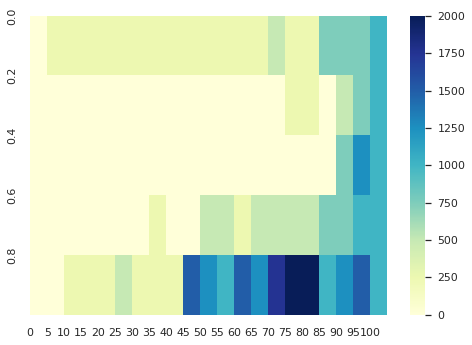

In [162]:
import seaborn as sns

sns.set_theme()
ax = sns.heatmap(dropout_average, cmap="YlGnBu")
plt.yticks([0, 1, 2, 3, 4], [0.0, 0.2, 0.4, 0.6, 0.8])
plt.xticks(list(range(21)), np.arange(0, 105, 5))
plt.show()

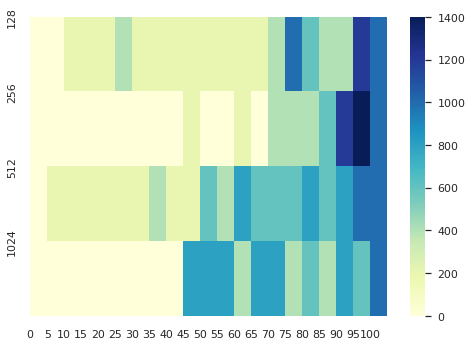

In [164]:
sns.set_theme()
ax = sns.heatmap(size_average, cmap="YlGnBu")
plt.yticks([0, 1, 2, 3], [128, 256, 512, 1024])
plt.xticks(list(range(21)), np.arange(0, 105, 5))
plt.show()